<a href="https://colab.research.google.com/github/Tikquuss/GflowNets_Tutorial/blob/main/2_Hypergrid_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Author TODO


In the  hyper-grid domain, the states are the cells of a n-dimensional hypercubic grid of side length $H$. The agent starts at coordinate $s = (0, 0, ..., 0)$ and is only allowed to increase coordinate $i$ (up to H, upon which the episode terminates). A stop action indicates to terminate the trajectory. There are many action sequences that lead to the same coordinate, making this Markov Decision Process a Directed Acyclic Graph. The reward for ending the trajectory in $x$ is some $R(x) \ge 0$ (see below for examples of reward functions).

In short, the non-terminal states form a n-dimensional hypergrid with side length $H$ : $\{ (s_0, ..., s_{n-1}) \ | \ s_i \in \{0, ..., H\}, 0 \leq i \leq n-1 \}$.



In each state $s = (s_0, ..., s_{n-1})$, we have $n+1$ possible actions:
- either choose a stop action and return the state as terminal $x = T(s, stop\_action) = s$, and then compute $R(x)$ 
- or we choose one of its $n$ coordinates $i$, and increment it : $s' = T(s, i) = (s_0, ..., s_i + 1, ..., s_{n-1})$


> Example : ndim=2 (H=2, ...)
```
|  ...   |   ...  | ...    | ...
................................
| (0, 2) | (1, 2) | (2, 2) | ...
................................
| (0, 1) | (1, 1) | (2, 1) | ...
................................
| (0, 0) | (1, 0) | (2, 0) | ...
................................
```

See below for an illustration of the reward function.

# Env

In [1]:
import torch

def build_grid(ndim, H):
    """
    > Example : ndim=2 (H=2, ...)
    ```
    |  ...   |   ...  | ...    | ...
    ---------------------------------
    | (0, 2) | (1, 2) | (2, 2) | ...
    ---------------------------------
    | (0, 1) | (1, 1) | (2, 1) | ...
    ---------------------------------
    | (0, 0) | (1, 0) | (2, 0) | ...
    ---------------------------------
    ```
    """
    # We have (H+1)^ndim points, each point being of dimension ndim.
    grid_shape = (H+1,)*ndim+(ndim,) # (H+1, ..., H+1, ndim)
    grid = torch.zeros(grid_shape)
    for i in range(ndim):
        grid_i = torch.linspace(start=0, end=H, steps=H+1)
        for _ in range(i): grid_i = grid_i.unsqueeze(1)
        grid[...,i] = grid_i
    #return grid.view((H+1)**ndim,-1) # ((H+1)*ndim, ndim)
    return grid

## Reward function

$$R(x) = R_0 + R_1 \prod_{i=1}^{n} \mathbb{I} (0.25 < |x_i/H - 0.5|) + R_2 \prod_{i=1}^{n} \mathbb{I} (0.3 < |x_i/H - 0.5| < 0.4), \ R_0 <<< R_1 < R_2$$

$$R_{cos}(x) = R_0 + R_1 \prod_{i=1}^{n} \big(cos(50\times|x_i/H - 0.5|)+1 \big) \times f_{\mathcal{N}} \big(5\times|x_i/H - 0.5|\big) \text{, } R_0 << R_1  \text{ and } f_{\mathcal{N}} \text{ the standard normal p.d.f}$$

$$\dots$$

$$\text{Any reward function with full support or with large enough support on the grid domain.}$$

We pave the hypercube and choose the reward values to give to each pavement. The mathematical trick is the following: 
* scale each point using the application from $[0, H]$ to $[0, 1]$ : $x \mapsto \frac{x}{H}$
- calculate the distance of each point (coordinates) from the center of the hypercube: $|\frac{x}{H}-0.5|$
- and use this distance to create the paving and assign different reward values to the paving stones. 

In the first function above, the paving is at three levels : in $]0.3, 0.4[^n$ (not in terms of coordinates, but in terms of absolute distance from the center $(1/2, ..., 1/2)$ of the hypercube) the reward is equal to $R_0+R_1+R_2$ (higher mode), between $(]0.25, 0.3[ \ U \ ]0.4, 1[)^n$ the reward is equal to $R_0+R_1$, between  $[0, 0.25]^n$ the reward is equal to $R_0 <<< R_1 < R_2$ (the desert of probability).

For the function with cosine, the paving is not strict, but smooth. 
* For the term with cosine, noted that $0 \le 50 \times |\frac{x}{H}-0.5| \le 25 ∼ 8\pi$, and that the function $x \mapsto cos(x) + 1$ varies from $2$ to $0$ between $[2k\pi, (2k+1)\pi]$ and from $0$ to $2$ between $[(2k+1)\pi, 2(k+1)\pi]$ for all $k \in \mathbb{N}$. So for this term the deserts of reward are $(2k+1)\pi $ and the high modes are $2k\pi$ ($k \le 4$), from the deserts to the high modes the reward function in $cos$ is continuously increasing
* For the term $f_{\mathcal{N}}$, noted that $0 \le 5 \times |x/H-0.5| \le 2.5$, and that $f_{\mathcal{N}(0, 1)}$ grows from $0.5$ to $0.99$ on this interval. Its high mode is therefore $0$, and the further away from $0$ (and thus from the center of the hypercube), the more it decreases.

By multiplying these two terms, instead of having peaks at regular intervals as with the $cos$ term, we have lower and lower peaks when we move away from the center of the hypercube. 

I dit a plot for $n=2$ below.

In [2]:
import numpy as np
from scipy.stats import norm

def get_reward_function(H, R0, r_cos = False, R1 = 0.5, R2 = 2):
    """ 
    x ~ (bs, n), 0 < r0 << r1 < r2
    R1 : 1e-1, 1e-2, 1e-3 ...
    """
    def R(x) :
        ax = abs(x/H - 0.5)
        return R0 + (0.25 < ax).prod(-1) * R1  + ((0.3 < ax) * (ax < 0.4)).prod(-1) * R2
        #ax = abs(x/H*2 - 1)
        #return R0 + (0.5 < ax).prod(-1) * R1  + ((0.6 < ax) * (ax < 0.8)).prod(-1) * R2

    def R_cos(x) :
        ax = abs(x/H - 0.5)
        return R0 + ((np.cos(ax * 50) + 1) * norm.pdf(ax * 5)).prod(-1) * R1

    return R if not r_cos else R_cos

## sanity check

In [3]:
R0, R1, R2 = 1e-2, 0.5, 2
R = get_reward_function(H=8, R0=R0, r_cos=False, R1=R1, R2=R2)
s_f = np.array([[4, 4], [0,0], [8, 8], [1,1]])
R(s_f) == np.array([R0, R0+R1, R0+R1, R0+R1+R2])

array([ True,  True,  True,  True])

In [4]:
ndim, H = 2, 8
grid = build_grid(ndim, H)
grid, grid.shape

(tensor([[[0., 0.],
          [1., 0.],
          [2., 0.],
          [3., 0.],
          [4., 0.],
          [5., 0.],
          [6., 0.],
          [7., 0.],
          [8., 0.]],
 
         [[0., 1.],
          [1., 1.],
          [2., 1.],
          [3., 1.],
          [4., 1.],
          [5., 1.],
          [6., 1.],
          [7., 1.],
          [8., 1.]],
 
         [[0., 2.],
          [1., 2.],
          [2., 2.],
          [3., 2.],
          [4., 2.],
          [5., 2.],
          [6., 2.],
          [7., 2.],
          [8., 2.]],
 
         [[0., 3.],
          [1., 3.],
          [2., 3.],
          [3., 3.],
          [4., 3.],
          [5., 3.],
          [6., 3.],
          [7., 3.],
          [8., 3.]],
 
         [[0., 4.],
          [1., 4.],
          [2., 4.],
          [3., 4.],
          [4., 4.],
          [5., 4.],
          [6., 4.],
          [7., 4.],
          [8., 4.]],
 
         [[0., 5.],
          [1., 5.],
          [2., 5.],
          [3., 5.],
     

In [5]:
R0, R1, R2 = 1e-2, 0.5, 2
R = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
all_rewards = R(grid)
all_rewards

tensor([[0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100]])

In [6]:
true_dist = all_rewards.flatten().softmax(0).cpu().numpy()
true_dist

array([0.01234862, 0.01234862, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.01234862, 0.01234862, 0.01234862,
       0.09124463, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.09124463, 0.01234862, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.01234862, 0.09124463,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.09124463, 0.01234862, 0.01234862, 0.01234862, 0.00748

In [7]:
grid.view((H+1)**ndim,-1)

tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [3., 0.],
        [4., 0.],
        [5., 0.],
        [6., 0.],
        [7., 0.],
        [8., 0.],
        [0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 1.],
        [6., 1.],
        [7., 1.],
        [8., 1.],
        [0., 2.],
        [1., 2.],
        [2., 2.],
        [3., 2.],
        [4., 2.],
        [5., 2.],
        [6., 2.],
        [7., 2.],
        [8., 2.],
        [0., 3.],
        [1., 3.],
        [2., 3.],
        [3., 3.],
        [4., 3.],
        [5., 3.],
        [6., 3.],
        [7., 3.],
        [8., 3.],
        [0., 4.],
        [1., 4.],
        [2., 4.],
        [3., 4.],
        [4., 4.],
        [5., 4.],
        [6., 4.],
        [7., 4.],
        [8., 4.],
        [0., 5.],
        [1., 5.],
        [2., 5.],
        [3., 5.],
        [4., 5.],
        [5., 5.],
        [6., 5.],
        [7., 5.],
        [8., 5.],
        [0., 6.],
        [1

## Plots



In [8]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

def plot(x, y, z) :
    """https://stackoverflow.com/a/30539444/11814682"""
    xyz = {'x': x, 'y': y, 'z': z}
    # put the data into a pandas DataFrame (this is what my data looks like)
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 

    # re-create the 2D-arrays
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    #surf = ax.plot_surface(x2, y2, z2 / z.sum() - 1.5, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_zlim(-1.01, 1.01)

    ax.zaxis.set_major_locator(ticker.LinearLocator(10))
    ax.zaxis.set_major_formatter(ticker.FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('2D grid domain')

    plt.show()

In [9]:
H = 4
N = 100
x, y = np.linspace(start = 0, stop = H, num=N), np.linspace(start = 0, stop = H, num=N)
xy = np.array(np.meshgrid(x, y)).T.reshape(-1,2) # (N*N,2)

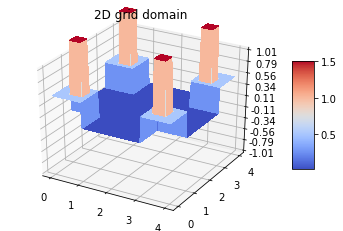

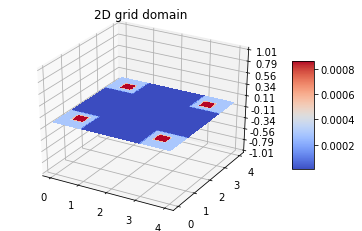

(None, None)

In [10]:
R0, R1, R2 = 1e-2, 0.5, 1
R = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
z = R(xy)
x, y = xy[:,0], xy[:,1]
plot(x, y, z), plot(x, y, z / z.sum())#, plot(x, y, z / np.log(z))

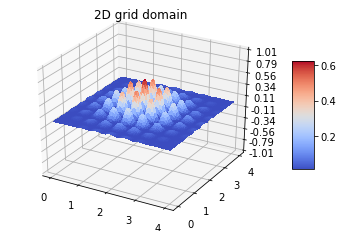

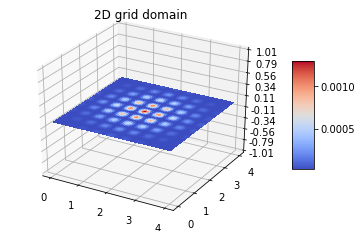

(None, None)

In [11]:
R0, R1 = 1e-2, 1
R = get_reward_function(H=H, R0=R0, r_cos=True, R1=R1)
z = R(xy)
x, y = xy[:,0], xy[:,1]
plot(x, y, z), plot(x, y, z / z.sum())#, plot(x, y, z / np.log(z))

# Gflownet agents

In [12]:
import torch
import numpy as np
import tqdm
import pickle

In [13]:
#H =  4 # horizon
H =  8 # horizon
#H =  100 # horizon
ndim = 2
#ndim = 4
#ndim = 6
#ndim = 8

grid = build_grid(ndim, H) # (H, ...., H, ndim)
grid = grid.view((H+1)**ndim,-1) # ((H+1)**ndim, ndim)

R0, R1, R2 = 1e-2, 0.5, 2
reward_function = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
#R0, R1 = 1e-2, 1
#reward_function = get_reward_function(H, R0=R0, r_cos=True, R1=R1)

all_rewards = reward_function(grid)
#print('total reward', all_rewards.view(-1).logsumexp(0))
print('total reward', all_rewards.view(-1).sum(0))
true_dist = all_rewards.flatten().softmax(0).cpu().numpy()

total reward tensor(16.8100)




## For debugging

Once our model is trained, we will generate some terminal states, display their rewards and see if they match the figure below



In [14]:
ar = all_rewards.reshape((H+1,)*ndim)

In [15]:
if ndim == 2 :
  print(ar)

tensor([[0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100]])


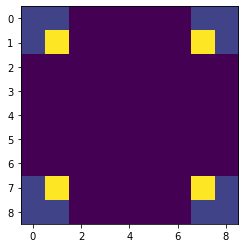

In [16]:
if ndim == 2 :
    plt.imshow(ar)
else :
    plt.imshow(ar[0,0])

In [17]:
if ndim == 4 :
    plt.imshow(ar.sum((0,1)),vmin=0);plt.show()

## Utils



In [18]:
def make_mlp(l, act=torch.nn.LeakyReLU(), tail=[]):
    return torch.nn.Sequential(*(sum(
        [[torch.nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))



---
**Re-execute the following cells each time H changes**


In [19]:
def one_hot_embedding(states, num_classes = H+1):
    # states : (bs, ndim) -> (bs, embedding_dim), embedding_dim = num_classes x ndim
    assert num_classes >= H + 1
    return torch.nn.functional.one_hot(states, num_classes).view(states.shape[0],-1).float()

The following function allows to associate a unique index to each state of the grid environment.\
Given that a coordinate can take $H+1$ values (from $0$ to $H$), it is enough to write them in this base to ensure the uniqueness.\
$$Index \bigg(s = (s_i)_{i=0}^{ndim-1} \bigg) = \sum_{i=0}^{ndim-1} s_i (H+1)^i $$
To find a state given its index, just invoke `grid[index]`

In [20]:
base_coordinates = (H+1)**torch.arange(ndim) # [(H+1)^0, ..., (H+1)^(ndim-1)]

In [21]:
def get_state_index(states):
    """
    This function allows to associate a unique index to each state of the grid environment.
    To find a state given its index, just invoke grid[state_index]
    > params : 
        * states ~ Tensor(num_states, ndim), batch_size can be zero (for single state)
    """
    state_index = (states*base_coordinates).sum().item()
    return state_index # (num_states,)

def get_state(indexes) :
    """
    This function allows to find a state given its index
    > params : 
        * indexes  ~ LongTensor(num_states,) or int (for single state)
    """
    return grid[indexes] # (num_states, ndim)

sanity check

In [22]:
for i, states in enumerate(grid) :
    assert i == get_state_index(states)



---



In [23]:
from typing import List

def get_modes_founds(first_visit : List[int], threshold : float = R2, max_steps : int = None) :
    """Calculates the modes (R >= threshold) found for each episode"""
    n = max_steps if max_steps is not None else n_train_steps
    xs = range(n)
    #modes_founds = [(reward_function(torch.stack([get_state(s) for s in list(set(np.where(first_visit == i)[0]))])) >= threshold).sum() for i in xs]
    
    # ((first_visit<np.arange(n_train_steps).unsqueeze(1)) - (first_visit==-1)) * batch_size
    # torch.from_numpy(first_visit) < torch.arange(n_train_steps).unsqueeze(1) & (torch.from_numpy(first_visit)!=-1)
    modes_founds = [0]*n
    for i in xs :
        states_i = list(set(np.where((0 <= first_visit) & (first_visit <= i))[0]))
        states_i = get_state(torch.LongTensor(states_i))
        r = reward_function(states_i)
        modes_founds[i] = (r >= threshold).sum().item()
    xs = [(i+1)*batch_size for i in xs]
    return modes_founds, xs

## Paramaters



In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
n_hid = 256
n_layers = 2

batch_size = 128

minus_inf = -1e8

# set PB to uniform distribution (and learn just PF) or not 
uniform_PB = False

In [26]:
#n_train_steps = 50000
n_train_steps = 5000
#n_train_steps = 1000
#n_train_steps = 50

## Trajectory Balance objective

$$ 
\mathcal{L}_{TB} \big(\tau = (s_0, ..., s_n = x) \big) = \bigg( log \frac{Z_{\theta} \prod_{t=1}^{n} P_{F} (s_t | s_{t-1}; \theta) }{R(x) \prod_{t=1}^{n} P_{B} (s_{t-1} | s_t; \theta) } \bigg)^2
\\= \bigg[ log(Z_{\theta}) + \sum_{t=1}^{n} \bigg( - log\big( P_{B} (s_{t-1} | s_t; \theta)\big) + log\big(P_{F} (s_t | s_{t-1}; \theta)\big) \bigg) - log \big(R(x)\big) \bigg]^2
$$

In [27]:
input_dim = ndim*(H+1) # embedding dim
output_dim = 2*ndim+1 # ndim + 1 for P_F (+1 for stop action) and ndim for P_B 
model_TB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_TB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([ {'params':model_TB.parameters(), 'lr':0.001}, {'params':[logZ_TB], 'lr':0.1} ])
logZ_TB.requires_grad_()

model_TB

Sequential(
  (0): Linear(in_features=18, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=5, bias=True)
)

In [28]:
losses_TB = []
rewards_TB = []
logZ_TB_list = []
all_visited_TB = []
first_visit_TB = -1 * np.ones_like(true_dist)
l1log_TB = []

In [29]:
for it in tqdm.trange(n_train_steps):
    
    # TB loss for each trajectory
    loss_TB = torch.zeros((batch_size,)).to(device)
    loss_TB += logZ_TB # see the equation above
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logits = model_TB(embed) # (current_batch_size, output_dim) 
        
        ### Backward Policy ### 
        PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
        PB_logits = PB_logits * (0 if uniform_PB else 1) # (current_batch_size, ndim)
        # Being in a edge cell -- (a zero coordinate), we can't move backward
        edge_mask = (non_terminal_states == 0).float() # (current_batch_size, ndim)
        logPB = (PB_logits + minus_inf*edge_mask).log_softmax(1) # (current_batch_size, ndim)
        # add -logPB to the loss
        if actions is not None: 
            """
            Gather along the parents' dimension (1) to select the logPB of the previously chosen actions, while avoiding the actions leading 
            to terminal states (action==ndim). The reason of using the previous chosen actions is that PB is calculated on the same trajectory as PF
            See below for the calculation of `action`. We avoid actions leading to terminal states because a terminal state can't be parent of another 
            state
            """
            loss_TB[~dones] -= logPB.gather(1, actions[actions != ndim].unsqueeze(1)).squeeze(1)

        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight = 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        # add logPF to the loss : gather along the children's dimension (1) to select the logPF for the chosen actions
        loss_TB[~dones] += logPF.gather(1, actions).squeeze(1)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_TB[state_index]<0: first_visit_TB[state_index] = it
            all_visited_TB.append(state_index)
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
        
    R = reward_function(states.float())
    loss_TB -= R.log()
    loss = (loss_TB**2).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_TB.append(loss.item())
    rewards_TB.append(R.mean().cpu())
    logZ_TB_list.append(logZ_TB.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_TB[-100:]).mean(), 'logZ =', logZ_TB.item(), "R =", np.array(rewards_TB[-100:]).mean())
        emp_dist = np.bincount(all_visited_TB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_TB.append((len(all_visited_TB), l1))

  0%|          | 5/5000 [00:00<04:00, 20.81it/s]


loss = 2.5257668495178223 logZ = 0.09999999403953552 R = 0.400625
L1 = 0.018172860720459327


  2%|▏         | 103/5000 [00:03<03:22, 24.16it/s]


loss = 0.7684746990539133 logZ = 2.7945196628570557 R = 1.3123437
L1 = 0.010999196767852545


  4%|▍         | 205/5000 [00:07<03:08, 25.50it/s]


loss = 0.01916250236798078 logZ = 2.8106842041015625 R = 1.6996874
L1 = 0.00979417047085417


  6%|▌         | 304/5000 [00:11<03:03, 25.55it/s]


loss = 0.01243523511220701 logZ = 2.8101961612701416 R = 1.7003124
L1 = 0.01024933333827744


  8%|▊         | 406/5000 [00:15<02:57, 25.93it/s]


loss = 0.006846476799692028 logZ = 2.8251802921295166 R = 1.680078
L1 = 0.010461126591087338


 10%|█         | 505/5000 [00:19<02:54, 25.78it/s]


loss = 0.0018569852419022936 logZ = 2.821643590927124 R = 1.7015624
L1 = 0.010589141703991362


 12%|█▏        | 604/5000 [00:23<02:57, 24.71it/s]


loss = 0.0005728609436482657 logZ = 2.8211722373962402 R = 1.6900389
L1 = 0.010676160949328052


 14%|█▍        | 706/5000 [00:27<02:53, 24.71it/s]


loss = 0.00020911895229801301 logZ = 2.8224334716796875 R = 1.6957811
L1 = 0.010741380001387866


 16%|█▌        | 805/5000 [00:31<02:50, 24.65it/s]


loss = 8.997209059998568e-05 logZ = 2.8204874992370605 R = 1.6847655
L1 = 0.01078694308878362


 18%|█▊        | 904/5000 [00:35<02:45, 24.76it/s]


loss = 4.889225427632482e-05 logZ = 2.821026563644409 R = 1.6801561
L1 = 0.010811687442319721


 20%|██        | 1003/5000 [00:39<02:43, 24.40it/s]


loss = 2.5417744632250104e-05 logZ = 2.8217668533325195 R = 1.6765623
L1 = 0.010839196210117056


 22%|██▏       | 1105/5000 [00:43<02:37, 24.73it/s]


loss = 7.196996288030277e-06 logZ = 2.822516918182373 R = 1.6674217
L1 = 0.01086065669365747


 24%|██▍       | 1204/5000 [00:47<02:32, 24.95it/s]


loss = 3.4641044001659794e-06 logZ = 2.8214948177337646 R = 1.6916014
L1 = 0.01087902525962554


 26%|██▌       | 1303/5000 [00:51<02:34, 23.99it/s]


loss = 2.130190291609324e-06 logZ = 2.8219025135040283 R = 1.6938671
L1 = 0.010896052779592123


 28%|██▊       | 1405/5000 [00:55<02:23, 25.00it/s]


loss = 8.235779304754943e-07 logZ = 2.822127103805542 R = 1.6960155
L1 = 0.010910511844720819


 30%|███       | 1504/5000 [00:59<02:20, 24.84it/s]


loss = 3.932433303077687e-07 logZ = 2.822007656097412 R = 1.6871483
L1 = 0.010923686894624396


 32%|███▏      | 1606/5000 [01:03<02:12, 25.53it/s]


loss = 6.17424205415773e-07 logZ = 2.8217101097106934 R = 1.6925389
L1 = 0.01107217366476118


 34%|███▍      | 1705/5000 [01:07<02:10, 25.23it/s]


loss = 6.585581277107622e-07 logZ = 2.821856737136841 R = 1.6753905
L1 = 0.011105753911674758


 36%|███▌      | 1804/5000 [01:10<02:05, 25.54it/s]


loss = 1.3886842884858197e-06 logZ = 2.8221194744110107 R = 1.6706249
L1 = 0.011092420578341426


 38%|███▊      | 1906/5000 [01:14<02:00, 25.72it/s]


loss = 4.5471360037936394e-05 logZ = 2.8228580951690674 R = 1.6925389
L1 = 0.011096618109205621


 40%|████      | 2005/5000 [01:18<02:02, 24.39it/s]


loss = 0.0001875528738128196 logZ = 2.8207616806030273 R = 1.6856248
L1 = 0.011092173664761179


 42%|████▏     | 2104/5000 [01:22<01:55, 25.14it/s]


loss = 0.0015125928373890928 logZ = 2.8219316005706787 R = 1.6993748
L1 = 0.011092544035131548


 44%|████▍     | 2205/5000 [01:27<01:50, 25.26it/s]


loss = 0.0005071019299793989 logZ = 2.8268074989318848 R = 1.6959764
L1 = 0.011092420578341427


 46%|████▌     | 2304/5000 [01:30<01:49, 24.56it/s]


loss = 0.0008161879267572658 logZ = 2.805758237838745 R = 1.6856248
L1 = 0.011083408232662411


 48%|████▊     | 2403/5000 [01:35<01:51, 23.25it/s]


loss = 0.003512929987628013 logZ = 2.8218674659729004 R = 1.6792967
L1 = 0.011086494652415499


 50%|█████     | 2505/5000 [01:39<01:39, 25.16it/s]


loss = 0.0006145200678292895 logZ = 2.81988263130188 R = 1.6700389
L1 = 0.011084642800563645


 52%|█████▏    | 2604/5000 [01:42<01:31, 26.14it/s]


loss = 2.9270158611325313e-05 logZ = 2.821341037750244 R = 1.6848435
L1 = 0.011087729220316733


 54%|█████▍    | 2703/5000 [01:46<01:33, 24.61it/s]


loss = 8.53104346958844e-06 logZ = 2.822500228881836 R = 1.6833982
L1 = 0.011093408232662413


 56%|█████▌    | 2805/5000 [01:50<01:28, 24.91it/s]


loss = 1.560849137263176e-06 logZ = 2.821622610092163 R = 1.6882421
L1 = 0.011093161319082166


 58%|█████▊    | 2904/5000 [01:54<01:22, 25.31it/s]


loss = 5.245730393426129e-06 logZ = 2.8227338790893555 R = 1.6818358
L1 = 0.011088099590687104


 60%|██████    | 3006/5000 [01:58<01:16, 26.16it/s]


loss = 3.275771387961868e-05 logZ = 2.8188438415527344 R = 1.6892186
L1 = 0.011084889714143894


 62%|██████▏   | 3105/5000 [02:02<01:14, 25.50it/s]


loss = 0.0006661311081188614 logZ = 2.811617851257324 R = 1.6787498
L1 = 0.011078840331427845


 64%|██████▍   | 3204/5000 [02:06<01:11, 25.23it/s]


loss = 0.0022135095699923114 logZ = 2.8184173107147217 R = 1.6777732
L1 = 0.011070939096859944


 66%|██████▌   | 3306/5000 [02:10<01:07, 25.20it/s]


loss = 0.0017029572580941022 logZ = 2.8145270347595215 R = 1.6802733
L1 = 0.011075506998094512


 68%|██████▊   | 3405/5000 [02:14<01:04, 24.91it/s]


loss = 0.0007221496640704572 logZ = 2.815289258956909 R = 1.6708592
L1 = 0.011070198356119205


 70%|███████   | 3504/5000 [02:17<00:59, 25.09it/s]


loss = 0.000137761759760906 logZ = 2.820422887802124 R = 1.6966796
L1 = 0.0110664946524155


 72%|███████▏  | 3606/5000 [02:21<00:53, 25.82it/s]


loss = 3.532718335918617e-05 logZ = 2.822187662124634 R = 1.6816014
L1 = 0.011065753911674758


 74%|███████▍  | 3705/5000 [02:25<00:50, 25.81it/s]


loss = 0.0002030001833827555 logZ = 2.8104469776153564 R = 1.6840624
L1 = 0.011067358849946364


 76%|███████▌  | 3804/5000 [02:29<00:45, 26.51it/s]


loss = 0.00042169795575318857 logZ = 2.81449818611145 R = 1.6858983
L1 = 0.011064889714143895


 78%|███████▊  | 3903/5000 [02:33<00:45, 23.89it/s]


loss = 0.003425623578950763 logZ = 2.8402979373931885 R = 1.6916014
L1 = 0.01106760576352661


 80%|████████  | 4005/5000 [02:37<00:38, 25.55it/s]


loss = 0.0028468675474869086 logZ = 2.8164520263671875 R = 1.6924217
L1 = 0.01106266749192167


 82%|████████▏ | 4104/5000 [02:41<00:37, 24.13it/s]


loss = 0.0005580554297921481 logZ = 2.821495294570923 R = 1.669492
L1 = 0.011061186010440193


 84%|████████▍ | 4203/5000 [02:44<00:33, 23.77it/s]


loss = 5.4378787399400605e-05 logZ = 2.8209245204925537 R = 1.6766405
L1 = 0.011054519343773528


 86%|████████▌ | 4305/5000 [02:49<00:27, 24.92it/s]


loss = 2.754190468294837e-06 logZ = 2.8224029541015625 R = 1.6817967
L1 = 0.011051062553650067


 88%|████████▊ | 4404/5000 [02:52<00:22, 25.99it/s]


loss = 7.381614040014028e-07 logZ = 2.8215818405151367 R = 1.6908983
L1 = 0.011048223047477228


 90%|█████████ | 4503/5000 [02:56<00:19, 25.38it/s]


loss = 8.586186821730734e-06 logZ = 2.8222599029541016 R = 1.6908592
L1 = 0.011053902059822906


 92%|█████████▏| 4605/5000 [03:00<00:15, 25.07it/s]


loss = 1.4044666831978248e-05 logZ = 2.8220672607421875 R = 1.6806248
L1 = 0.011056000825255005


 94%|█████████▍| 4704/5000 [03:04<00:11, 25.28it/s]


loss = 0.00012432600853571786 logZ = 2.821392774581909 R = 1.6797264
L1 = 0.01105871687463772


 96%|█████████▌| 4806/5000 [03:08<00:07, 25.87it/s]


loss = 0.0065718289534561335 logZ = 2.832035779953003 R = 1.685078
L1 = 0.01105970452895871


 98%|█████████▊| 4905/5000 [03:12<00:03, 24.92it/s]


loss = 0.0016031729691894725 logZ = 2.823831081390381 R = 1.681992
L1 = 0.011058716874637721


100%|██████████| 5000/5000 [03:16<00:00, 25.45it/s]


### samples

In [30]:
#model_TB, logZ_TB, losses_TB, rewards_TB, logZ_TB_list, all_visited_TB, first_visit_TB, l1log_TB = data["TB"]

In [31]:
samples_TB = np.zeros((H+1,)*ndim)

In [32]:
for it in tqdm.trange(500):
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logits = model_TB(embed) # (current_batch_size, output_dim) 
        
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight = 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        
        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        
        # Update dones
        dones[~dones] |= terminates
        
        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
    
    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_TB[a,b,c,d,e,f,g,h]+=1
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_TB[a,b,c,d,e,f]+=1
    if ndim == 4 :
        for a,b,c,d in states: samples_TB[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_TB[a,b]+=1

100%|██████████| 500/500 [00:07<00:00, 66.99it/s]


In [33]:
if ndim == 2 :
    print(samples_TB / samples_TB.sum())

[[0.0319375  0.03085938 0.000625   0.00057812 0.00054688 0.00067187
  0.0006875  0.03004688 0.02959375]
 [0.030375   0.14814062 0.00059375 0.00065625 0.00057812 0.00064063
  0.00064063 0.15059375 0.03045313]
 [0.0005625  0.00071875 0.00075    0.00064063 0.0005625  0.00059375
  0.00075    0.0005625  0.00064063]
 [0.00070312 0.00053125 0.00057812 0.0005     0.00054688 0.00051563
  0.00070312 0.00064063 0.0006875 ]
 [0.00070312 0.000625   0.00070312 0.00060937 0.00064063 0.00067187
  0.00054688 0.000625   0.00059375]
 [0.0005     0.00057812 0.00089063 0.0005625  0.00065625 0.00051563
  0.00045313 0.00053125 0.00040625]
 [0.0005     0.00076563 0.00054688 0.0005625  0.000625   0.00060937
  0.00078125 0.00075    0.00071875]
 [0.03039063 0.14840625 0.000625   0.00042187 0.0005625  0.00057812
  0.00048437 0.148      0.02998438]
 [0.03021875 0.03045313 0.00046875 0.00065625 0.00053125 0.00064063
  0.00073438 0.0304375  0.03032813]]


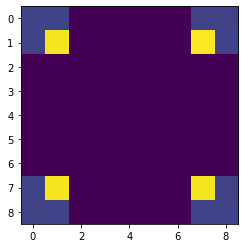

In [34]:
if ndim == 2 :
    plt.imshow(samples_TB)
elif ndim == 4 :
    plt.imshow(samples_TB[0,0])
elif ndim == 6:  
    plt.imshow(samples_TB[0,0,0,0])
elif ndim == 8:  
    plt.imshow(samples_TB[0,0,0,0,0,0])

In [35]:
if ndim == 4 :
    tmp = samples_TB.sum((2,3))+samples_TB.sum((0,1))+samples_TB.sum((0,2))+samples_TB.sum((1,3))+samples_TB.sum((2,3))+samples_TB.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_TB.sum((1,3)),vmin=0);plt.show()

## Detailed balance objective

$$ 
\mathcal{L}_{DB} \big(s, s' \big) = \left\{
    \begin{array}{ll}
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta)}{R(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta) }{F_{\theta}(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{else.}
    \end{array}
\right. 
\\= \left\{
    \begin{array}{ll}
        \bigg[ log(F_{\theta} (s)) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) - log(R(s'))  \bigg]^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg[ log(F_{\theta} (s)) - log(F_{\theta} (s')) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) \bigg]^2 & \mbox{else.}
    \end{array}
\right. 
$$

In [36]:
input_dim = ndim*(H+1) # embedding dim
output_dim = 2*ndim+2 # ndim + 1 for P_F (+1 for stop action), ndim for P_B, and 1 for F
model_DB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_DB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([{'params':model_DB.parameters(), 'lr':0.001}])

model_DB

Sequential(
  (0): Linear(in_features=18, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=6, bias=True)
)

In [37]:
losses_DB = []
rewards_DB = []
logZ_DB_list = []
all_visited_DB = []
first_visit_DB = -1 * np.ones_like(true_dist)
l1log_DB = []

In [38]:
for it in tqdm.trange(n_train_steps):
    
    # DB loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
    loss_DB = torch.zeros((batch_size, H+1+(ndim-1)*H)).to(device)
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    i = 0
    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logits = model_DB(embed) # (current_batch_size, output_dim) 

        ### logF ### 
        logF = logits[...,2*ndim+1] # (current_batch_size,)
        loss_DB[~dones,i] += logF # add logF(s_i) to the loss L(s_i, s_{i+1})
        if i>0: loss_DB[~dones,i-1] -= logF # add -logF(s_i) to the loss L(s_{i-1}, s_i)
        #else : logZ_DB[:] = logF.mean().item() # initial state : Z = F(s_0)
        else: logZ_DB[:] = logF[0].item() # initial state : Z = F(s_0)
        
        ### Backward Policy ### 
        PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
        PB_logits = PB_logits * (0 if uniform_PB else 1) # (current_batch_size, ndim)
        # Being in a edge cell -- (a zero coordinate), we can't move backward
        edge_mask = (non_terminal_states == 0).float() # (current_batch_size, ndim)
        logPB = (PB_logits + minus_inf*edge_mask).log_softmax(1) # (current_batch_size, ndim)
        # add -logPB(s_{i-1} | s_i) to the loss L(s_{i-1}, s_i)
        if actions is not None: 
            """
            Gather along the parents' dimension (1) to select the logPB of the previously chosen actions, while avoiding the actions leading 
            to terminal states (action==ndim). The reason of using the previous chosen actions () is that PB is calculated on the same trajectory as PF
            See below for the calculation of `action`. We avoid actions leading to terminal states because a terminal state can't be parent of another 
            state
            """
            loss_DB[~dones,i-1] -= logPB.gather(1, actions[actions!=ndim].unsqueeze(1)).squeeze(1)
    
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        # add logPF(s_i | s_{i+1}) to the loss L(s_i, s_{i+1}) : gather along the children's dimension (1) to select the logPF for the chosen actions
        loss_DB[~dones,i] += logPF.gather(1, actions).squeeze(1)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_DB[state_index]<0: first_visit_DB[state_index] = it
            all_visited_DB.append(state_index)

        # Add reward for terminal state
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        R_x = reward_function(non_terminal_states[terminates].float()) 
        loss_DB[termination_mask,i] -= (R_x + 1e-8).log()
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
            
        i += 1

    #lens = states.sum(1)+1 # number of actions taken for each trajectory
    #loss = (loss_DB**2).sum()/lens.sum() 
    loss = (loss_DB**2).sum(dim=1).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_DB.append(loss.item())
    R = reward_function(states.float())
    rewards_DB.append(R.mean().cpu())
    logZ_DB_list.append(logZ_DB.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_DB[-100:]).mean(), 'logZ =', logZ_DB.item(), "R =", np.array(rewards_DB[-100:]).mean())
        emp_dist = np.bincount(all_visited_DB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_DB.append((len(all_visited_DB), l1))

  0%|          | 4/5000 [00:00<02:32, 32.66it/s]


loss = 4.886329174041748 logZ = -0.04554392397403717 R = 0.50609374
L1 = 0.01945942918551557


  2%|▏         | 104/5000 [00:04<04:04, 20.03it/s]


loss = 1.5021616424620152 logZ = 2.4866504669189453 R = 0.93238294
L1 = 0.012451822715909904


  4%|▍         | 203/5000 [00:10<04:10, 19.15it/s]


loss = 0.034051602160325274 logZ = 2.812350273132324 R = 1.6316404
L1 = 0.009873466853249843


  6%|▌         | 302/5000 [00:14<03:51, 20.27it/s]


loss = 0.007473673899366986 logZ = 2.8091483116149902 R = 1.7096483
L1 = 0.00986032652969699


  8%|▊         | 403/5000 [00:20<04:02, 18.96it/s]


loss = 0.009545504381385399 logZ = 2.810619831085205 R = 1.707578
L1 = 0.01022493081509522


 10%|█         | 502/5000 [00:25<04:01, 18.66it/s]


loss = 0.009939709907630458 logZ = 2.8165524005889893 R = 1.7053124
L1 = 0.010426272996960976


 12%|█▏        | 603/5000 [00:30<03:53, 18.81it/s]


loss = 0.0031778376092552207 logZ = 2.821881055831909 R = 1.6958592
L1 = 0.010561254723079618


 14%|█▍        | 703/5000 [00:35<03:46, 18.93it/s]


loss = 0.0012494139652881131 logZ = 2.820671796798706 R = 1.6818358
L1 = 0.01063488531126265


 16%|█▌        | 805/5000 [00:40<03:30, 19.97it/s]


loss = 0.0004694717856546049 logZ = 2.821624755859375 R = 1.7033201
L1 = 0.010681943165847783


 18%|█▊        | 902/5000 [00:45<03:29, 19.58it/s]


loss = 0.0002724844165641116 logZ = 2.8224081993103027 R = 1.686953
L1 = 0.010727333295349962


 20%|██        | 1004/5000 [00:50<03:28, 19.12it/s]


loss = 0.00018346759651649336 logZ = 2.82171630859375 R = 1.6937108
L1 = 0.010764618010538856


 22%|██▏       | 1104/5000 [00:55<03:22, 19.21it/s]


loss = 0.00010379326192378358 logZ = 2.8220651149749756 R = 1.672031
L1 = 0.010792501761553094


 24%|██▍       | 1203/5000 [01:00<03:24, 18.59it/s]


loss = 4.945847240378498e-05 logZ = 2.8209822177886963 R = 1.6984373
L1 = 0.010821524308771828


 26%|██▌       | 1303/5000 [01:05<03:09, 19.54it/s]


loss = 5.1232887913101876e-05 logZ = 2.8225948810577393 R = 1.6947654
L1 = 0.01083689244708437


 28%|██▊       | 1402/5000 [01:10<03:09, 18.98it/s]


loss = 3.1371117142953156e-05 logZ = 2.82185959815979 R = 1.6868749
L1 = 0.0108519943395878


 30%|███       | 1504/5000 [01:16<03:01, 19.22it/s]


loss = 6.553622686624295e-05 logZ = 2.822242021560669 R = 1.6773045
L1 = 0.010860328927507825


 32%|███▏      | 1603/5000 [01:21<03:25, 16.50it/s]


loss = 0.00024235265892912138 logZ = 2.8129642009735107 R = 1.6923827
L1 = 0.011072790948711794


 34%|███▍      | 1704/5000 [01:27<02:50, 19.29it/s]


loss = 0.0011526551427050436 logZ = 2.8220534324645996 R = 1.6964842
L1 = 0.011126247738835252


 36%|███▌      | 1803/5000 [01:32<02:41, 19.81it/s]


loss = 2.8009715383348065e-06 logZ = 2.8221774101257324 R = 1.6951952
L1 = 0.011107852677106858


 38%|███▊      | 1903/5000 [01:37<02:37, 19.61it/s]


loss = 3.0229638866785533e-07 logZ = 2.8219845294952393 R = 1.6809373
L1 = 0.011092420578341424


 40%|████      | 2004/5000 [01:42<02:34, 19.40it/s]


loss = 1.4670297595387184e-07 logZ = 2.8219640254974365 R = 1.6909374
L1 = 0.011073778603032783


 42%|████▏     | 2104/5000 [01:47<02:35, 18.61it/s]


loss = 5.065244236046595e-08 logZ = 2.821986436843872 R = 1.7001952
L1 = 0.011069827985748832


 44%|████▍     | 2203/5000 [01:52<02:30, 18.57it/s]


loss = 3.868631012871049e-08 logZ = 2.821930408477783 R = 1.6830858
L1 = 0.011062667491921672


 46%|████▌     | 2303/5000 [01:57<02:22, 18.87it/s]


loss = 0.00012066460790313371 logZ = 2.8219680786132812 R = 1.6672654
L1 = 0.011060815640069818


 48%|████▊     | 2404/5000 [02:03<02:10, 19.84it/s]


loss = 0.0015785660973779158 logZ = 2.8271610736846924 R = 1.6837889
L1 = 0.011059827985748833


 50%|█████     | 2504/5000 [02:08<02:08, 19.47it/s]


loss = 0.00022763586319115347 logZ = 2.8223049640655518 R = 1.6771873
L1 = 0.011052420578341425


 52%|█████▏    | 2603/5000 [02:13<02:02, 19.56it/s]


loss = 1.0037438844889834e-06 logZ = 2.8219127655029297 R = 1.6828904
L1 = 0.011047235393156241


 54%|█████▍    | 2704/5000 [02:18<02:04, 18.47it/s]


loss = 3.0424473691503805e-08 logZ = 2.8219690322875977 R = 1.6986717
L1 = 0.011048716874637722


 56%|█████▌    | 2804/5000 [02:23<01:52, 19.57it/s]


loss = 8.408867517850637e-09 logZ = 2.821962833404541 R = 1.7010936
L1 = 0.011048223047477228


 58%|█████▊    | 2903/5000 [02:28<01:47, 19.49it/s]


loss = 6.2017183577456335e-09 logZ = 2.8219733238220215 R = 1.6692185
L1 = 0.011048593417847597


 60%|██████    | 3002/5000 [02:33<01:47, 18.59it/s]


loss = 9.099521870137295e-07 logZ = 2.822744369506836 R = 1.6702342
L1 = 0.011054148973403155


 62%|██████▏   | 3102/5000 [02:38<01:41, 18.68it/s]


loss = 0.0017605254292993777 logZ = 2.817831039428711 R = 1.6796874
L1 = 0.011056247738835252


 64%|██████▍   | 3205/5000 [02:44<01:30, 19.82it/s]


loss = 3.00251169448984e-05 logZ = 2.821889877319336 R = 1.6795702
L1 = 0.011054519343773524


 66%|██████▌   | 3303/5000 [02:49<01:27, 19.48it/s]


loss = 5.027107514976592e-07 logZ = 2.82195782661438 R = 1.6883202
L1 = 0.011053408232662413


 68%|██████▊   | 3402/5000 [02:54<01:23, 19.09it/s]


loss = 1.4276240820620956e-08 logZ = 2.8219680786132812 R = 1.6832421
L1 = 0.011046000825255005


 70%|███████   | 3503/5000 [02:59<01:17, 19.41it/s]


loss = 1.8528302325737655e-09 logZ = 2.8219754695892334 R = 1.6950389
L1 = 0.011043778603032782


 72%|███████▏  | 3603/5000 [03:04<01:12, 19.36it/s]


loss = 4.6746805248965015e-09 logZ = 2.821959972381592 R = 1.6858592
L1 = 0.011041432924020439


 74%|███████▍  | 3704/5000 [03:09<01:07, 19.31it/s]


loss = 0.00150514964563482 logZ = 2.8209662437438965 R = 1.6876171
L1 = 0.011038840331427843


 76%|███████▌  | 3804/5000 [03:14<01:02, 19.02it/s]


loss = 0.0008101269267308453 logZ = 2.8221240043640137 R = 1.6905468
L1 = 0.011040198356119205


 78%|███████▊  | 3903/5000 [03:19<00:58, 18.73it/s]


loss = 1.37135693258017e-06 logZ = 2.8219218254089355 R = 1.6862108
L1 = 0.01105007489932908


 80%|████████  | 4003/5000 [03:24<00:53, 18.76it/s]


loss = 6.271170942540038e-08 logZ = 2.8219542503356934 R = 1.6999998
L1 = 0.011054766257353769


 82%|████████▏ | 4104/5000 [03:30<00:46, 19.07it/s]


loss = 1.4071780694013824e-08 logZ = 2.8219449520111084 R = 1.6896092
L1 = 0.011062667491921674


 84%|████████▍ | 4202/5000 [03:34<00:41, 19.33it/s]


loss = 2.217409897087297e-09 logZ = 2.821972370147705 R = 1.6768749
L1 = 0.011062790948711794


 86%|████████▌ | 4302/5000 [03:40<00:37, 18.63it/s]


loss = 6.969761486008696e-10 logZ = 2.8219709396362305 R = 1.6933202
L1 = 0.01106044526969945


 88%|████████▊ | 4403/5000 [03:45<00:33, 18.04it/s]


loss = 8.658092396807149e-08 logZ = 2.8220627307891846 R = 1.6729686
L1 = 0.01106007489932908


 90%|█████████ | 4503/5000 [03:50<00:25, 19.70it/s]


loss = 0.003331016466261758 logZ = 2.822216033935547 R = 1.6939843
L1 = 0.011055877368464882


 92%|█████████▏| 4604/5000 [03:55<00:21, 18.07it/s]


loss = 0.00030744258857339445 logZ = 2.8213813304901123 R = 1.6899217
L1 = 0.011055630454884635


 94%|█████████▍| 4703/5000 [04:00<00:15, 18.78it/s]


loss = 3.7179143080834364e-06 logZ = 2.8220372200012207 R = 1.6885154
L1 = 0.01105550699809451


 96%|█████████▌| 4804/5000 [04:05<00:10, 18.63it/s]


loss = 9.335215540140495e-08 logZ = 2.8219869136810303 R = 1.6948436
L1 = 0.011056988479575994


 98%|█████████▊| 4903/5000 [04:10<00:05, 18.12it/s]


loss = 2.313515849117209e-08 logZ = 2.8219921588897705 R = 1.7174999
L1 = 0.011070198356119203


100%|██████████| 5000/5000 [04:16<00:00, 19.52it/s]


### samples

In [39]:
#model_DB, logZ_DB, losses_DB, rewards_DB, logZ_DB_list, all_visited_DB, first_visit_DB, l1log_DB = data["TB"]

In [40]:
samples_DB = np.zeros((H+1,)*ndim)

In [41]:
for it in tqdm.trange(500):
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logits = model_DB(embed) # (current_batch_size, output_dim) 
        
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)

        # Add reward for terminal state
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
            
    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_DB[a,b,c,d,e,f,g,h]+=1  
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_DB[a,b,c,d,e,f]+=1         
    if ndim == 4 :
        for a,b,c,d in states: samples_DB[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_DB[a,b]+=1

100%|██████████| 500/500 [00:07<00:00, 63.60it/s]


In [42]:
if ndim == 2 :
    print(samples_DB / samples_DB.sum())

[[0.02926562 0.03035938 0.00048437 0.00054688 0.00064063 0.00054688
  0.00054688 0.02959375 0.02996875]
 [0.02917187 0.15064063 0.00048437 0.000375   0.000625   0.00060937
  0.00057812 0.15075    0.03020313]
 [0.00053125 0.00064063 0.00057812 0.0006875  0.00057812 0.00071875
  0.00054688 0.00070312 0.00076563]
 [0.00064063 0.0006875  0.00059375 0.00075    0.00075    0.00034375
  0.00048437 0.00060937 0.00057812]
 [0.00060937 0.0006875  0.00071875 0.00059375 0.0005     0.00054688
  0.0006875  0.00073438 0.00059375]
 [0.0006875  0.000625   0.0005     0.0006875  0.00048437 0.00070312
  0.00054688 0.00075    0.00051563]
 [0.00057812 0.000625   0.00064063 0.00053125 0.00059375 0.00054688
  0.00059375 0.00064063 0.00070312]
 [0.02996875 0.15048438 0.00060937 0.00053125 0.00045313 0.00051563
  0.00048437 0.15025    0.03076563]
 [0.02945313 0.02907812 0.0004375  0.00045313 0.00051563 0.00076563
  0.00039063 0.0314375  0.03020313]]


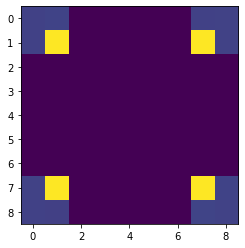

In [43]:
if ndim == 2 :
    plt.imshow(samples_DB)
elif ndim == 4 :
    plt.imshow(samples_DB[0,0])
elif ndim == 6:  
    plt.imshow(samples_DB[0,0,0,0])
elif ndim == 8:
    plt.imshow(samples_DB[0,0,0,0,0,0])

In [44]:
if ndim == 4 :
    tmp = samples_DB.sum((2,3))+samples_DB.sum((0,1))+samples_DB.sum((0,2))+samples_DB.sum((1,3))+samples_DB.sum((2,3))+samples_DB.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_DB.sum((1,3)),vmin=0);plt.show()

## Flow matching objective

$$
\mathcal{L}_{FM} \big(s\big) = \left\{
    \begin{array}{ll}
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta}^{log}(s'', s) \bigg) - log \bigg( \epsilon + R(s) \bigg) \bigg]^2 & \mbox{if } s \mbox{ terminal} \\
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta} ^{log}(s'', s) \bigg) - log \bigg( \epsilon +  \sum_{s \rightarrow s'} exp \text{ } F_{\theta}^{log}(s, s') \bigg) \bigg]^2 & \mbox{else (s non-initial)}
    \end{array}
\right. 
$$


In [45]:
epsilon = all_rewards.min()
#epsilon = 1e-6
epsilon

tensor(0.0100)



---


The following functions allow, in a given state, to find all its parents, to evaluate the model on these parents, and to consider the flow from the parents to the current state.

In [46]:
def get_parents(state) :
    """
    Return the parents of a given state, and the trasitions leading from the parents to the current state
    For `state = [3., 1.]`, `parents = [[2., 1.], [3., 0.]]` and `transitions = [0, 1]`
    """
    assert state.sum() != 0.
    parents, transitions = [], []
    np = 0
    for i in range(ndim) :
        sp = state + 0
        if sp[i] > 0 :
            sp[i] -= 1
            np += 1
            # if sp.max() == H: # can't have a terminal parent
            #     np -= 1
            #     continue
            parents.append(sp)
            transitions.append(i)
    if np == 0 : return None, None
    return torch.stack(parents), torch.LongTensor(transitions)

def get_inflow_old(state, model) :
    """Return the in flow of a given state"""
    parents, transitions = get_parents(state)
    embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
    logF = model(embed) # (n_parents, ndim+1)
    return logF.gather(1, transitions.unsqueeze(1).to(device)).exp().sum()

It is better to store the parents of each state to accelerate the training

In [47]:
all_parents = {get_state_index(state.long()) : get_parents(state) for state in grid if state.sum() != 0.}

In [48]:
def get_inflow(state, model, stop_action = False) :
    """Return the in flow of a given state"""
    if stop_action:
        #parents, transitions = state.unsqueeze(0), torch.LongTensor([ndim])         
        # Any state can be a parent of the terminal state : the corresponding action is always ndim
        parents = grid.clone()
        transitions = torch.LongTensor([ndim]*grid.size(0)) 
    else :
        state_id = get_state_index(state.long().cpu())
        parents, transitions = all_parents.get(state_id, (None, None))
    if parents is not None :
        embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
        logF = model(embed.to(device)) # (n_parents, ndim+1)
        return logF.gather(1, transitions.unsqueeze(1).to(device)).exp().sum()
    #else : return torch.tensor(0.)

In [49]:
# for debugging
def parents_flow(non_terminal_states, actions, model):
    a = actions[actions!=ndim]
    parents = []
    print(non_terminal_states.shape, a.shape)
    print(non_terminal_states, actions)
    for n, i in zip(non_terminal_states, a) :
        s = n+0
        s[i]-=1
        parents.append(s)
    parents = torch.stack(parents)
    print(parents)
    embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
    logF = model(embed.to(device)) # (n_parents, ndim+1)
    return logF.gather(1, a.unsqueeze(1).to(device)).exp().sum(dim=1)



---



In [50]:
input_dim = ndim*(H+1) # embedding dim
output_dim = ndim+1 # ndim + 1 for F (+1 for stop action)
model_FM = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_FM = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([{'params':model_FM.parameters(), 'lr':0.001}])

model_FM

Sequential(
  (0): Linear(in_features=18, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=3, bias=True)
)

In [51]:
losses_FM = []
rewards_FM = []
logZ_FM_list = []
all_visited_FM = []
first_visit_FM = -1 * np.ones_like(true_dist)
l1log_FM = []

In [52]:
# #batch_size = 128
# #batch_size = 8
# #epsilon = 1e-2
# for it in tqdm.trange(n_train_steps): 
# #for it in tqdm.trange(1000):    
#     # FM loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
#     loss_FM = torch.zeros((batch_size, H+1+(ndim-1)*H +1)).to(device) # +1 for s_f
#     # finished trajectories
#     dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
#     # s_0
#     states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
#     # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
#     actions = None # (current_batch_size,)

#     current_batch_size = (~dones).sum()
#     non_terminal_states = states[~dones] # (current_batch_size, ndim)

#     i = 0
#     while True:
#         if actions is not None :
#             ### select terminals and non-terminal actions ### 
#             # non-terminals
#             terminates = (actions==ndim).squeeze(1)
#             termination_mask = ~dones
#             termination_mask[~dones] &= terminates
#             # terminals
#             non_terminates = (actions!=ndim).squeeze(1)
#             non_termination_mask = ~dones
#             non_termination_mask[~dones] &= non_terminates

#             ### In Flow : non-initial and non-terminal state ### 
#             if non_terminates.any(): 
#                 #inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states[non_terminates]]) # (current_batch_size,)
#                 #inFlow = torch.tensor(0.) if i==0 else parents_flow(non_terminal_states[non_terminates], actions, model_FM)
#                 inFlow = logPF.gather(1, actions[actions!=ndim].unsqueeze(1)).exp().sum(dim=1)
#                 loss_FM[non_termination_mask,i] += (epsilon + inFlow).log()  

#             ### In Flow : terminal state ###
#             if terminates.any():
#                 # add log_sumF(., s_i) to the loss L(s_i)   
#                 inFlow = torch.stack([get_inflow(state, model_FM, stop_action=True) for state in non_terminal_states[terminates]]) # (current_batch_size,)
#                 loss_FM[termination_mask,i] += (epsilon + inFlow).log() 

#             ### Out Flow for non-terminal states : add -log_sumF(s_i, .) to the loss L(s_i) ###
#             #outFlow = logF[non_terminates].exp().sum(dim=-1)
#             outFlow = logPF[non_terminates].exp().sum(dim=-1)
#             loss_FM[non_termination_mask,i] -= (epsilon + outFlow).log()

#             ### Out Flow for terminal states : Add -reward for terminal state ###
#             R_x = reward_function(non_terminal_states[terminates].float())
#             loss_FM[termination_mask,i] -= (epsilon + R_x).log()

#             ### select terminal states ### 
#             for state in non_terminal_states[terminates]: 
#                 state_index = get_state_index(state.cpu())
#                 if first_visit_FM[state_index]<0: first_visit_FM[state_index] = it
#                 all_visited_FM.append(state_index)

#             # Update dones
#             dones[~dones] |= terminates

#             # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
#             with torch.no_grad():
#                 non_terminates = actions[~terminates]
#                 states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

#             i += 1

#         if torch.any(~dones) :
#             ### Forward pass ### 
#             current_batch_size = (~dones).sum()
#             non_terminal_states = states[~dones] # (current_batch_size, ndim)
#             embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
#             logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

#             ### Forward Policy : tempered version of the state-action flow F ### 
#             # Being in a edge cell ++ (a coordinate that is H), we can't move forward
#             edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
#             # but any cell can be a terminal cell
#             stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
#             # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
#             PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
#             # logPF (with mask)
#             logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
#             # choose next states
#             sample_temperature = 1
#             #exp_weight= 0.
#             #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
#             PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
#             #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
#             #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
#             actions = PF.multinomial(1) # (current_batch_size,)
#         else :
#             break

#         if i==0 :
#             # initial state
#             #all_init_flow = logF.exp().sum(dim=1) # (current_batch_size,)
#             all_init_flow = logPF.exp().sum(dim=1) # (current_batch_size,)
#             #logZ_FM[:] = all_init_flow.mean().item() 
#             logZ_FM[:] = all_init_flow[0].item() # initial state)

#     loss_FM = loss_FM[:,1:] # remove L(s_0)
#     loss = (loss_FM**2).sum(dim=1).sum()/batch_size

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     losses_FM.append(loss.item())
#     R = reward_function(states.float())
#     rewards_FM.append(R.mean().cpu())
#     logZ_FM_list.append(logZ_FM.item())

#     if it%100==0: 
#         print('\nloss =', np.array(losses_FM[-100:]).mean(), 'logZ =', logZ_FM.item(), "R =", np.array(rewards_FM[-100:]).mean())
#         emp_dist = np.bincount(all_visited_FM[-200000:], minlength=len(true_dist)).astype(float)
#         emp_dist /= emp_dist.sum()
#         l1 = np.abs(true_dist-emp_dist).mean()
#         print('L1 =', l1)
#         l1log_FM.append((len(all_visited_FM), l1))

In [53]:
for it in tqdm.trange(n_train_steps): 
#for it in tqdm.trange(100):    
    # FM loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
    loss_FM = torch.zeros((batch_size, H+1+(ndim-1)*H)).to(device)
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    i = 0
    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

        ### Forward Policy : tempered version of the state-action flow F ### 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = PF.multinomial(1) # (current_batch_size,)
        
        ### Out Flow for non-terminal states : add -log_sumF(s_i, .) to the loss L(s_i) ###
        non_terminates = (actions!=ndim).squeeze(1)
        termination_mask = ~dones
        termination_mask[~dones] &= non_terminates
        #outFlow = logF[non_terminates].exp().sum(dim=-1)
        outFlow = logPF[non_terminates].exp().sum(dim=-1)
        loss_FM[termination_mask,i] -= (epsilon + outFlow).log()

        ### In Flow : non-initial and non-terminal state ###
        if i!=0 :
            # add log_sumF(., s_i) to the loss L(s_i)
            #inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states]) # (current_batch_size,)
            #loss_FM[~dones,i] += (epsilon + inFlow).log()    
            if non_terminates.any(): 
                inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states[non_terminates]]) # (current_batch_size,)
                loss_FM[termination_mask,i] += (epsilon + inFlow).log()      
        else :
            # initial state
            #all_init_flow = logF.exp().sum(dim=1) # (current_batch_size,)
            all_init_flow = logPF.exp().sum(dim=1) # (current_batch_size,)
            #logZ_FM[:] = all_init_flow.mean().item() 
            logZ_FM[:] = all_init_flow[0].item() # initial state)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_FM[state_index]<0: first_visit_FM[state_index] = it
            all_visited_FM.append(state_index)

        # Add -reward for terminal state : Out Flow for terminal states
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        R_x = reward_function(non_terminal_states[terminates].float())
        loss_FM[termination_mask,i] -= (epsilon + R_x).log()

        ### In Flow : terminal state ###
        if i!=0 and terminates.any():
            # add log_sumF(., s_i) to the loss L(s_i)   
            inFlow = torch.stack([get_inflow(state, model_FM, stop_action=True) for state in non_terminal_states[terminates]]) # (current_batch_size,)
            #print(inFlow, "===========", non_terminal_states[terminates])
            loss_FM[termination_mask,i] += (epsilon + inFlow).log()           

        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

        i += 1
    
    loss_FM = loss_FM[:,1:] # remove L(s_0)
    loss = (loss_FM**2).sum(dim=1).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_FM.append(loss.item())
    R = reward_function(states.float())
    rewards_FM.append(R.mean().cpu())
    logZ_FM_list.append(logZ_FM.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_FM[-100:]).mean(), 'logZ =', logZ_FM.item(), "R =", np.array(rewards_FM[-100:]).mean())
        emp_dist = np.bincount(all_visited_FM[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_FM.append((len(all_visited_FM), l1))

  0%|          | 1/5000 [00:00<20:52,  3.99it/s]


loss = 31.729785919189453 logZ = 1.0 R = 0.5178125
L1 = 0.0174551492349969


  2%|▏         | 101/5000 [01:34<1:22:44,  1.01s/it]


loss = 5.9953792859613895 logZ = 0.9999999403953552 R = 0.45992187
L1 = 0.01919801058146368


  4%|▍         | 201/5000 [03:18<1:22:02,  1.03s/it]


loss = 0.6387750022113323 logZ = 0.9999999403953552 R = 0.48390624
L1 = 0.02053159034222513


  6%|▌         | 301/5000 [05:02<1:24:54,  1.08s/it]


loss = 0.6375275936722755 logZ = 1.0000001192092896 R = 0.48460937
L1 = 0.02105024376821686


  8%|▊         | 401/5000 [06:45<1:18:29,  1.02s/it]


loss = 0.6301479159295559 logZ = 0.9999999403953552 R = 0.48382813
L1 = 0.021332826552877788


 10%|█         | 501/5000 [08:28<1:17:47,  1.04s/it]


loss = 0.6304317580163479 logZ = 0.9999998807907104 R = 0.48371094
L1 = 0.021492590996159563


 12%|█▏        | 601/5000 [10:12<1:15:30,  1.03s/it]


loss = 0.6720246708393097 logZ = 1.0 R = 0.48277342
L1 = 0.021573511866360168


 14%|█▍        | 701/5000 [11:54<1:13:33,  1.03s/it]


loss = 0.6259366954863071 logZ = 0.9999999403953552 R = 0.485
L1 = 0.021670150468468905


 16%|█▌        | 801/5000 [13:38<1:12:20,  1.03s/it]


loss = 0.6174059319496155 logZ = 1.0000001192092896 R = 0.48453125
L1 = 0.021750376969939908


 18%|█▊        | 901/5000 [15:20<1:09:41,  1.02s/it]


loss = 0.6437408241629601 logZ = 1.0 R = 0.4828125
L1 = 0.021804445371030944


 20%|██        | 1001/5000 [17:02<1:08:56,  1.03s/it]


loss = 0.6069959345459938 logZ = 0.9999999403953552 R = 0.4865625
L1 = 0.02184925256298945


 22%|██▏       | 1101/5000 [18:44<1:05:05,  1.00s/it]


loss = 0.6498643511533737 logZ = 1.0 R = 0.48296875
L1 = 0.02187540806333508


 24%|██▍       | 1201/5000 [20:28<1:06:12,  1.05s/it]


loss = 0.6322371484339238 logZ = 1.0 R = 0.48375
L1 = 0.02190411448209644


 26%|██▌       | 1301/5000 [22:12<1:03:32,  1.03s/it]


loss = 0.6313940727710724 logZ = 0.9999998807907104 R = 0.48265624
L1 = 0.021933449154680273


 28%|██▊       | 1401/5000 [23:55<1:01:19,  1.02s/it]


loss = 0.6276248665153981 logZ = 0.9999999403953552 R = 0.48332033
L1 = 0.021952400179817772


 30%|███       | 1501/5000 [25:37<1:00:07,  1.03s/it]


loss = 0.6149423509836197 logZ = 0.9999999403953552 R = 0.48566407
L1 = 0.021973838175721853


 32%|███▏      | 1601/5000 [27:20<58:28,  1.03s/it]


loss = 0.630598445981741 logZ = 1.0 R = 0.48351562
L1 = 0.02221719375759731


 34%|███▍      | 1701/5000 [29:04<55:42,  1.01s/it]


loss = 0.650153606235981 logZ = 1.0 R = 0.48285156
L1 = 0.022223736967473852


 36%|███▌      | 1801/5000 [30:46<56:00,  1.05s/it]


loss = 0.6370745453238488 logZ = 1.0 R = 0.48441407
L1 = 0.022224477708214594


 38%|███▊      | 1901/5000 [32:30<53:27,  1.04s/it]


loss = 0.6498939417302608 logZ = 1.0 R = 0.48117188
L1 = 0.022220527090930645


 40%|████      | 2001/5000 [34:16<51:06,  1.02s/it]


loss = 0.6230124348402023 logZ = 1.0 R = 0.48371094
L1 = 0.022220156720560276


 42%|████▏     | 2101/5000 [35:59<50:41,  1.05s/it]


loss = 0.6391803397238255 logZ = 0.9999999403953552 R = 0.483125
L1 = 0.02222583573290595


 44%|████▍     | 2201/5000 [37:43<47:40,  1.02s/it]


loss = 0.6262872090935707 logZ = 1.0 R = 0.483125
L1 = 0.02222867523907879


 46%|████▌     | 2301/5000 [39:26<46:09,  1.03s/it]


loss = 0.613329156935215 logZ = 0.9999999403953552 R = 0.48574218
L1 = 0.02222583573290595


 48%|████▊     | 2401/5000 [41:08<43:58,  1.02s/it]


loss = 0.6201966565102339 logZ = 1.0 R = 0.48335937
L1 = 0.02222669993043682


 50%|█████     | 2501/5000 [42:51<43:11,  1.04s/it]


loss = 0.6386800900101661 logZ = 1.0 R = 0.48160157
L1 = 0.022220033263770148


 52%|█████▏    | 2601/5000 [44:33<40:46,  1.02s/it]


loss = 0.6235570140182972 logZ = 1.0 R = 0.4842969
L1 = 0.022220280177350397


 54%|█████▍    | 2701/5000 [46:17<39:17,  1.03s/it]


loss = 0.6440181303024292 logZ = 1.0 R = 0.48078126
L1 = 0.022228428325498546


 56%|█████▌    | 2801/5000 [48:00<39:08,  1.07s/it]


loss = 0.6189899942278863 logZ = 1.0 R = 0.4840625
L1 = 0.022224107337844225


 58%|█████▊    | 2901/5000 [49:57<46:34,  1.33s/it]


loss = 0.6596446719765663 logZ = 1.0 R = 0.48246095
L1 = 0.022220280177350397


 60%|██████    | 3001/5000 [51:40<33:59,  1.02s/it]


loss = 0.6115902163088321 logZ = 1.0 R = 0.48425782
L1 = 0.022222132029202247


 62%|██████▏   | 3101/5000 [53:25<32:06,  1.01s/it]


loss = 0.6145773753523827 logZ = 1.0 R = 0.48367187
L1 = 0.022224107337844225


 64%|██████▍   | 3201/5000 [55:18<33:26,  1.12s/it]


loss = 0.6211089174449443 logZ = 1.0 R = 0.48421875
L1 = 0.02222065054772077


 66%|██████▌   | 3301/5000 [57:25<29:12,  1.03s/it]


loss = 0.6410890728235245 logZ = 1.0000001192092896 R = 0.48289064
L1 = 0.02221744067117756


 68%|██████▊   | 3401/5000 [59:37<35:09,  1.32s/it]


loss = 0.5920486937463284 logZ = 0.9999999403953552 R = 0.4835547
L1 = 0.022225218448955333


 70%|███████   | 3501/5000 [1:01:32<25:30,  1.02s/it]


loss = 0.5890399028360843 logZ = 0.9999999403953552 R = 0.485
L1 = 0.02223373696747385


 72%|███████▏  | 3601/5000 [1:03:16<24:30,  1.05s/it]


loss = 0.6076247088611126 logZ = 1.0 R = 0.48183593
L1 = 0.022228798695868916


 74%|███████▍  | 3701/5000 [1:04:58<22:37,  1.04s/it]


loss = 0.5988446632027626 logZ = 1.0 R = 0.48441407
L1 = 0.022226576473646696


 76%|███████▌  | 3801/5000 [1:06:40<20:26,  1.02s/it]


loss = 0.5824089112132788 logZ = 1.0 R = 0.48453125
L1 = 0.02221867523907879


 78%|███████▊  | 3901/5000 [1:08:23<18:25,  1.01s/it]


loss = 0.5857080771028995 logZ = 0.9999998807907104 R = 0.48351562
L1 = 0.02221645301685657


 80%|████████  | 4001/5000 [1:10:06<16:54,  1.02s/it]


loss = 0.5361063117533922 logZ = 0.9999999403953552 R = 0.4859375
L1 = 0.022223490053893607


 82%|████████▏ | 4101/5000 [1:11:47<15:14,  1.02s/it]


loss = 0.5622745031490922 logZ = 1.0000001192092896 R = 0.48621094
L1 = 0.022230527090930645


 84%|████████▍ | 4201/5000 [1:13:29<13:20,  1.00s/it]


loss = 0.5620338312536478 logZ = 1.0 R = 0.48640624
L1 = 0.02224451184581827


 86%|████████▌ | 4301/5000 [1:15:11<11:58,  1.03s/it]


loss = 0.5367334872484207 logZ = 1.0 R = 0.48539063
L1 = 0.022260067401373825


 88%|████████▊ | 4401/5000 [1:16:53<10:21,  1.04s/it]


loss = 0.5389569989591837 logZ = 1.0 R = 0.48585936
L1 = 0.022278585919892346


 90%|█████████ | 4501/5000 [1:18:35<08:39,  1.04s/it]


loss = 0.5728485667705536 logZ = 0.9999998807907104 R = 0.48433593
L1 = 0.02229265999396642


 92%|█████████▏| 4601/5000 [1:20:18<06:50,  1.03s/it]


loss = 0.5573164594173431 logZ = 1.0 R = 0.4853125
L1 = 0.022306980981620744


 94%|█████████▍| 4701/5000 [1:22:03<05:14,  1.05s/it]


loss = 0.5487520867586135 logZ = 1.0 R = 0.48617187
L1 = 0.022319697031003456


 96%|█████████▌| 4801/5000 [1:23:47<03:22,  1.02s/it]


loss = 0.5131358911097049 logZ = 0.9999998807907104 R = 0.4876953
L1 = 0.022341919253225682


 98%|█████████▊| 4901/5000 [1:25:30<01:40,  1.01s/it]


loss = 0.5112637519091368 logZ = 0.9999999403953552 R = 0.48808593
L1 = 0.022360437771744197


100%|██████████| 5000/5000 [1:27:11<00:00,  1.05s/it]


In [54]:
#loss_FM[:,1:], loss_FM.shape

(tensor([[-9.5030e-03, -3.0932e-03, -2.7801e-03,  ..., -1.8894e-03,
          -5.8512e-04, -1.5973e-01],
         [-2.9981e-03, -3.0932e-03, -3.3951e-04,  ..., -1.0063e-03,
           5.1672e-04, -1.5973e-01],
         [-9.5030e-03, -3.0932e-03, -2.7801e-03,  ..., -1.8894e-03,
          -5.8512e-04, -1.5973e-01],
         ...,
         [ 1.3315e-02, -3.6825e-05, -5.3470e-04,  ..., -1.0063e-03,
           5.1672e-04, -1.5973e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.3315e-02,  1.1894e-02,  1.4933e-02,  ..., -1.0063e-03,
           5.1672e-04, -1.5973e-01]], grad_fn=<SliceBackward0>),
 torch.Size([128, 16]))

In [55]:
#loss_FM[loss_FM != 0].shape

torch.Size([1947])

### samples

In [56]:
#model_FM, logZ_FM, losses_FM, rewards_FM, logZ_FM_list, all_visited_FM, first_visit_FM, l1log_FM = data["FM"]

In [57]:
samples_FM = np.zeros((H+1,)*ndim)

In [58]:
# #batch_size = 128
# #batch_size = 8
# #batch_size = 1
# epsilon = 1e-2
# for it in tqdm.trange(100):    
#     # finished trajectories
#     dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
#     # s_0
#     states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
#     # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
#     actions = None # (current_batch_size,)

#     current_batch_size = (~dones).sum()
#     non_terminal_states = states[~dones] # (current_batch_size, ndim)

#     i = 0
#     while torch.any(~dones):

#         if actions is not None :  
#             ### select terminal states ### 
#             terminates = (actions==ndim).squeeze(1)

#             # Update dones
#             dones[~dones] |= terminates

#             # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
#             with torch.no_grad():
#                 non_terminates = actions[~terminates]
#                 states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
#             i += 1

#         if torch.any(~dones) :
#             ### Forward pass ### 
#             current_batch_size = (~dones).sum()
#             non_terminal_states = states[~dones] # (current_batch_size, ndim)
#             embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
#             logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

#             ### Forward Policy : tempered version of the state-action flow F ### 
#             # Being in a edge cell ++ (a coordinate that is H), we can't move forward
#             edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
#             # but any cell can be a terminal cell
#             stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
#             # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
#             PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
#             # logPF (with mask)
#             logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
#             # choose next states
#             sample_temperature = 1
#             #exp_weight= 0.
#             #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
#             PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
#             #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
#             #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
#             actions = PF.multinomial(1) # (current_batch_size,)
#         else :
#             break

#     if ndim == 8 :
#         for a,b,c,d,e,f,g,h in states: samples_FM[a,b,c,d,e,f,g,h]+=1  
#     if ndim == 6 :
#         for a,b,c,d,e,f in states: samples_FM[a,b,c,d,e,f]+=1         
#     if ndim == 4 :
#         for a,b,c,d in states: samples_FM[a,b,c,d]+=1
#     elif ndim == 2 :
#         for a,b in states: samples_FM[a,b]+=1

In [59]:
for it in tqdm.trange(500):    
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

        ### Forward Policy : tempered version of the flow F ### 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = PF.multinomial(1) # (current_batch_size,)
        
        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)

        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_FM[a,b,c,d,e,f,g,h]+=1  
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_FM[a,b,c,d,e,f]+=1         
    if ndim == 4 :
        for a,b,c,d in states: samples_FM[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_FM[a,b]+=1

100%|██████████| 500/500 [00:09<00:00, 54.24it/s]


In [60]:
if ndim == 2 :
    print(samples_FM / samples_FM.sum())

[[2.7421875e-02 5.3437500e-03 9.1562500e-03 3.1562500e-03 1.2187500e-03
  5.3125000e-04 3.4375000e-04 3.1250000e-04 5.7812500e-04]
 [1.3593750e-03 6.4062500e-04 1.0937500e-03 4.5312500e-04 2.6562500e-04
  9.3750000e-05 6.2500000e-05 6.2500000e-05 1.4062500e-04]
 [1.8125000e-03 5.9375000e-04 1.5000000e-03 7.9687500e-04 1.5625000e-04
  2.5000000e-04 1.4062500e-04 1.0937500e-04 4.3750000e-04]
 [3.1250000e-04 3.1250000e-04 7.9687500e-04 1.2500000e-04 2.3437500e-04
  6.2500000e-05 1.4062500e-04 3.1250000e-05 3.2812500e-04]
 [8.2812500e-04 5.7812500e-04 1.4687500e-03 9.0625000e-04 8.4375000e-04
  4.0625000e-04 3.9062500e-04 1.4062500e-04 1.2031250e-03]
 [3.1250000e-04 4.2187500e-04 8.5937500e-04 5.9375000e-04 5.0000000e-04
  3.2812500e-04 3.5937500e-04 2.0312500e-04 9.6875000e-04]
 [2.1875000e-04 9.3750000e-05 3.9062500e-04 2.1875000e-04 4.6875000e-04
  2.0312500e-04 3.4375000e-04 1.4062500e-04 9.8437500e-04]
 [2.0312500e-04 1.4062500e-04 7.9687500e-04 3.1250000e-04 5.3125000e-04
  2.0312500

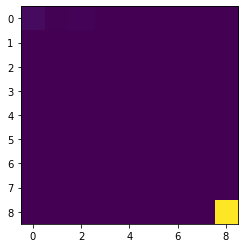

In [61]:
if ndim == 2 :
    plt.imshow(samples_FM)
elif ndim == 4 :
    plt.imshow(samples_FM[0,0])
elif ndim == 6:  
    plt.imshow(samples_FM[0,0,0,0])
elif ndim == 8:
    plt.imshow(samples_FM[0,0,0,0,0,0])

In [62]:
if ndim == 4 :
    tmp = samples_FM.sum((2,3))+samples_FM.sum((0,1))+samples_FM.sum((0,2))+samples_FM.sum((1,3))+samples_FM.sum((2,3))+samples_FM.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_FM.sum((1,3)),vmin=0);plt.show()

**This implementation has a problem. Refer to this official implementation for the moment : https://github.com/GFNOrg/gflownet**

## Random (uniform) agent

In [63]:
rewards_random = []
all_visited_random = []
first_visit_random = -1 * np.ones_like(true_dist)
l1log_random = []

In [64]:
for it in tqdm.trange(n_train_steps):

    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)

    while torch.any(~dones) : #and i <= max_length_traj :
        # Forward pass
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        
        ### Uniform Forward Policy ### 
        PF_logits = torch.ones(current_batch_size, ndim+1).to(device) # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # PF (with mask)
        PF = (PF_logits + minus_inf*PF_mask).softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        #actions = torch.from_numpy(np.random.choice(np.arange(ndim+1), size=(current_batch_size,1), p = PF))
        actions = PF.multinomial(1)
        #if i == max_length_traj : actions = torch.LongTensor(current_batch_size,1).fill_(ndim)
        # select terminal states
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_random[state_index]<0: first_visit_random[state_index] = it
            all_visited_random.append(state_index)
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    R = reward_function(states.float())
    rewards_random.append(R.mean().cpu())
    if it%100==0: 
        print("\nR =", np.array(rewards_random[-100:]).mean())
        emp_dist = np.bincount(all_visited_random[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_random.append((len(all_visited_random), l1))

  0%|          | 16/5000 [00:00<00:33, 147.73it/s]


R = 0.5178125
L1 = 0.018518825579020712


  2%|▎         | 125/5000 [00:00<00:33, 143.72it/s]


R = 0.47816408
L1 = 0.017191706462517924


  4%|▍         | 221/5000 [00:01<00:31, 151.74it/s]


R = 0.4777344
L1 = 0.01718213309297474


  7%|▋         | 331/5000 [00:02<00:30, 150.85it/s]


R = 0.47808594
L1 = 0.017193770743694114


  9%|▊         | 427/5000 [00:02<00:30, 149.89it/s]


R = 0.47691405
L1 = 0.01719816092845943


 10%|█         | 522/5000 [00:03<00:29, 150.78it/s]


R = 0.48257813
L1 = 0.01717692653538787


 12%|█▏        | 621/5000 [00:04<00:28, 155.48it/s]


R = 0.47464845
L1 = 0.01719100360197735


 14%|█▍        | 719/5000 [00:04<00:27, 158.12it/s]


R = 0.479375
L1 = 0.01718978200389468


 16%|█▋        | 816/5000 [00:05<00:28, 146.67it/s]


R = 0.48117188
L1 = 0.017196090189399486


 19%|█▊        | 927/5000 [00:06<00:27, 148.46it/s]


R = 0.47507814
L1 = 0.01720399546722726


 20%|██        | 1018/5000 [00:06<00:27, 145.87it/s]


R = 0.47183594
L1 = 0.0172095504348614


 22%|██▎       | 1125/5000 [00:07<00:26, 147.85it/s]


R = 0.47527343
L1 = 0.017203058380420518


 24%|██▍       | 1220/5000 [00:08<00:26, 144.43it/s]


R = 0.47058594
L1 = 0.01719138336406458


 26%|██▋       | 1317/5000 [00:08<00:25, 143.51it/s]


R = 0.48242188
L1 = 0.01719885089014956


 28%|██▊       | 1423/5000 [00:09<00:25, 139.98it/s]


R = 0.47515625
L1 = 0.017188454422063036


 31%|███       | 1529/5000 [00:10<00:24, 139.20it/s]


R = 0.4744922
L1 = 0.017181627983693337


 32%|███▏      | 1619/5000 [00:10<00:23, 143.35it/s]


R = 0.483125
L1 = 0.01717237847102277


 34%|███▍      | 1714/5000 [00:11<00:22, 147.68it/s]


R = 0.47351563
L1 = 0.017175217977195612


 36%|███▋      | 1821/5000 [00:12<00:22, 142.49it/s]


R = 0.48597658
L1 = 0.017163859952504253


 39%|███▊      | 1927/5000 [00:13<00:21, 144.33it/s]


R = 0.4745703
L1 = 0.017161884643862275


 40%|████      | 2023/5000 [00:13<00:19, 149.06it/s]


R = 0.4789453
L1 = 0.017164724150035116


 42%|████▏     | 2117/5000 [00:14<00:19, 147.07it/s]


R = 0.47964844
L1 = 0.017169292051269682


 44%|████▍     | 2223/5000 [00:15<00:19, 141.46it/s]


R = 0.47261718
L1 = 0.01717274884139314


 46%|████▋     | 2314/5000 [00:15<00:19, 138.25it/s]


R = 0.48089844
L1 = 0.017171020446331415


 48%|████▊     | 2421/5000 [00:16<00:17, 144.07it/s]


R = 0.47335938
L1 = 0.01717151427349191


 51%|█████     | 2530/5000 [00:17<00:17, 143.39it/s]


R = 0.47667968
L1 = 0.017171020446331415


 52%|█████▏    | 2623/5000 [00:17<00:16, 147.37it/s]


R = 0.47140625
L1 = 0.017165217977195613


 55%|█████▍    | 2730/5000 [00:18<00:15, 146.53it/s]


R = 0.4823828
L1 = 0.01716163773028203


 56%|█████▋    | 2824/5000 [00:19<00:15, 143.79it/s]


R = 0.47914064
L1 = 0.017167934026578326


 58%|█████▊    | 2914/5000 [00:19<00:14, 139.55it/s]


R = 0.47585937
L1 = 0.017171020446331415


 60%|██████    | 3019/5000 [00:20<00:14, 137.75it/s]


R = 0.4729297
L1 = 0.0171762056315166


 62%|██████▏   | 3124/5000 [00:21<00:13, 141.41it/s]


R = 0.47101563
L1 = 0.01718262538460302


 64%|██████▍   | 3223/5000 [00:22<00:14, 126.55it/s]


R = 0.4803125
L1 = 0.017178674767319067


 66%|██████▋   | 3321/5000 [00:22<00:12, 133.19it/s]


R = 0.48035157
L1 = 0.017181884643862277


 68%|██████▊   | 3422/5000 [00:23<00:12, 130.21it/s]


R = 0.48410156
L1 = 0.017191514273491908


 70%|███████   | 3522/5000 [00:24<00:11, 130.80it/s]


R = 0.48523438
L1 = 0.01718114390312154


 72%|███████▏  | 3620/5000 [00:25<00:10, 129.35it/s]


R = 0.4879297
L1 = 0.017176082174726475


 74%|███████▍  | 3721/5000 [00:25<00:09, 133.35it/s]


R = 0.48410156
L1 = 0.017162378471022772


 76%|███████▋  | 3822/5000 [00:26<00:08, 135.35it/s]


R = 0.47652343
L1 = 0.017150773532751164


 79%|███████▊  | 3928/5000 [00:27<00:07, 140.13it/s]


R = 0.4794922
L1 = 0.01714657600188697


 80%|████████  | 4021/5000 [00:28<00:06, 148.22it/s]


R = 0.48152342
L1 = 0.017142255014232645


 82%|████████▏ | 4116/5000 [00:28<00:06, 143.14it/s]


R = 0.47851562
L1 = 0.01713669945867709


 85%|████████▍ | 4226/5000 [00:29<00:05, 145.94it/s]


R = 0.48
L1 = 0.017144353779664747


 86%|████████▋ | 4317/5000 [00:30<00:04, 143.70it/s]


R = 0.47464845
L1 = 0.01715027970559067


 89%|████████▊ | 4427/5000 [00:30<00:04, 142.88it/s]


R = 0.4794922
L1 = 0.017145958717936352


 90%|█████████ | 4518/5000 [00:31<00:03, 142.90it/s]


R = 0.47765625
L1 = 0.01713731674262771


 92%|█████████▏| 4624/5000 [00:32<00:02, 135.22it/s]


R = 0.48085937
L1 = 0.01712694637225734


 95%|█████████▍| 4729/5000 [00:32<00:01, 138.57it/s]


R = 0.4785547
L1 = 0.017131637730282027


 96%|█████████▋| 4822/5000 [00:33<00:01, 143.66it/s]


R = 0.4674219
L1 = 0.01714213155744252


 98%|█████████▊| 4914/5000 [00:34<00:00, 142.64it/s]


R = 0.46980467
L1 = 0.017145341433985734


100%|██████████| 5000/5000 [00:34<00:00, 143.50it/s]


### samples

In [65]:
samples_random = np.zeros((H+1,)*ndim)

In [66]:
for it in tqdm.trange(500):

    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)

    while torch.any(~dones) : #and i <= max_length_traj :
        # Forward pass
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        
        ### Uniform Forward Policy ### 
        PF_logits = torch.ones(current_batch_size, ndim+1).to(device) # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # PF (with mask)
        PF = (PF_logits + minus_inf*PF_mask).softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        #actions = torch.from_numpy(np.random.choice(np.arange(ndim+1), size=(current_batch_size,1), p = PF))
        actions = PF.multinomial(1)
        #if i == max_length_traj : actions = torch.LongTensor(current_batch_size,1).fill_(ndim)
        # select terminal states
        terminates = (actions==ndim).squeeze(1)
 
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_random[a,b,c,d,e,f,g,h]+=1  
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_random[a,b,c,d,e,f]+=1         
    if ndim == 4 :
        for a,b,c,d in states: samples_random[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_random[a,b]+=1

100%|██████████| 500/500 [00:02<00:00, 188.44it/s]


In [67]:
if ndim == 2 :
    print(samples_random / samples_random.sum())

[[3.29375000e-01 1.10078125e-01 3.73906250e-02 1.28281250e-02
  4.35937500e-03 1.10937500e-03 4.37500000e-04 1.40625000e-04
  3.12500000e-05]
 [1.11078125e-01 7.59375000e-02 3.76093750e-02 1.62343750e-02
  7.31250000e-03 3.15625000e-03 1.34375000e-03 5.15625000e-04
  2.18750000e-04]
 [3.68125000e-02 3.67343750e-02 2.45625000e-02 1.36562500e-02
  7.09375000e-03 3.34375000e-03 1.29687500e-03 7.18750000e-04
  5.46875000e-04]
 [1.28281250e-02 1.58593750e-02 1.51562500e-02 9.32812500e-03
  5.29687500e-03 2.51562500e-03 1.85937500e-03 5.62500000e-04
  4.53125000e-04]
 [4.01562500e-03 7.25000000e-03 6.32812500e-03 5.17187500e-03
  3.45312500e-03 2.12500000e-03 1.28125000e-03 6.09375000e-04
  4.37500000e-04]
 [1.54687500e-03 3.01562500e-03 2.82812500e-03 2.90625000e-03
  1.92187500e-03 1.29687500e-03 8.90625000e-04 6.40625000e-04
  5.78125000e-04]
 [4.53125000e-04 1.01562500e-03 1.43750000e-03 1.17187500e-03
  1.29687500e-03 9.06250000e-04 7.81250000e-04 3.28125000e-04
  4.21875000e-04]
 [1.25

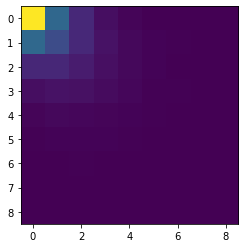

In [68]:
if ndim == 2 :
    plt.imshow(samples_random)
elif ndim == 4 :
    plt.imshow(samples_random[0,0])
elif ndim == 6:  
    plt.imshow(samples_random[0,0,0,0])
elif ndim == 8:
    plt.imshow(samples_random[0,0,0,0,0,0])

In [69]:
if ndim == 4 :
    tmp = samples_random.sum((2,3))+samples_random.sum((0,1))+samples_random.sum((0,2))+samples_random.sum((1,3))+samples_random.sum((2,3))+samples_random.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_random.sum((1,3)),vmin=0);plt.show()

## Saves models

In [70]:
data = {
    "TB" : [model_TB, logZ_TB, losses_TB, rewards_TB, logZ_TB_list, all_visited_TB, first_visit_TB, l1log_TB],
    "DB" : [model_DB, logZ_DB, losses_DB, rewards_DB, logZ_DB_list, all_visited_DB, first_visit_DB, l1log_DB],
    "FM" : [model_FM, logZ_FM, losses_FM, rewards_FM, logZ_FM_list, all_visited_FM, first_visit_FM, l1log_FM],
    "random" : [None, None, None, rewards_random, None, all_visited_random, first_visit_random, l1log_random],
}

torch.save(data, "/content/data_gfn.pth")

## Plot

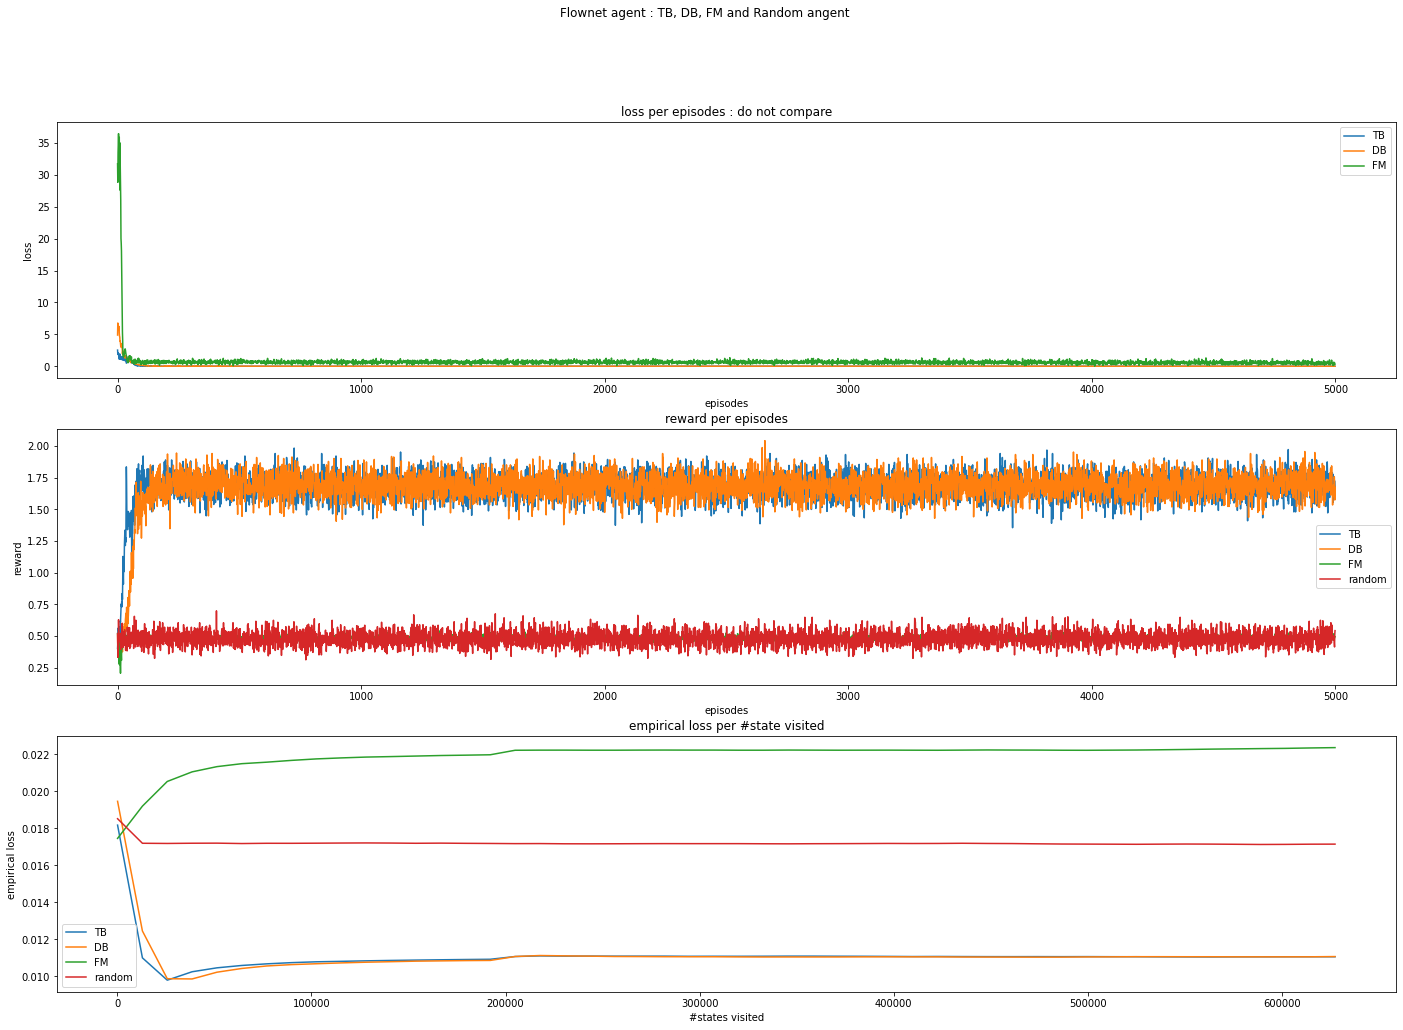

In [75]:
figsize=(6*4,4*4)
#fig, (ax1, ax2, ax3, ax4)  = plt.subplots(4, 1, sharex=False, sharey=False, figsize = figsize)
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1, sharex=False, sharey=False, figsize = figsize)
fig.suptitle("Flownet agent : TB, DB, FM and Random angent")

## loss
xs_TB = list(range(len(losses_TB)))
ax1.plot(xs_TB, losses_TB, label="TB")
#-
xs_DB = list(range(len(losses_DB)))
ax1.plot(xs_DB, losses_DB, label="DB")
#-
xs_FM = list(range(len(losses_FM)))
ax1.plot(xs_FM, losses_FM, label="FM")
#-
ax1.set(xlabel='episodes', ylabel='loss')
ax1.set_title('loss per episodes : do not compare')
ax1.legend()

## rewards
ax2.plot(xs_TB, rewards_TB, label="TB")
ax2.plot(xs_DB, rewards_DB, label="DB")
ax2.plot(xs_FM, rewards_FM, label="FM")
xs_random = list(range(len(rewards_random)))
ax2.plot(xs_random, rewards_random, label="random")
ax2.set(xlabel='episodes', ylabel='reward')
ax2.set_title('reward per episodes')
ax2.legend()

## empirical loss
xs = [a[0] for a in l1log_TB]
emp_loss_TB = [a[1] for a in l1log_TB]
ax3.plot(xs, emp_loss_TB, label="TB")
#-
xs = [a[0] for a in l1log_DB]
emp_loss_DB = [a[1] for a in l1log_DB]
ax3.plot(xs, emp_loss_DB, label="DB")
#-
xs = [a[0] for a in l1log_FM]
emp_loss_FM = [a[1] for a in l1log_FM]
ax3.plot(xs, emp_loss_FM, label="FM")
#-
xs = [a[0] for a in l1log_random]
emp_loss_random = [a[1] for a in l1log_random]
ax3.plot(xs, emp_loss_random, label="random")
#-
ax3.set(xlabel='#states visited', ylabel='empirical loss')
ax3.set_title('empirical loss per #state visited')
ax3.legend()


# ## empiciral loss
# xs = list(range(len(emp_loss_TB)))
# ax4.plot(xs, emp_loss_TB, label="TB")
# #-
# xs = list(range(len(emp_loss_DB)))
# ax4.plot(xs, emp_loss_DB, label="DB")
# #-
# xs = list(range(len(emp_loss_FM)))
# ax4.plot(xs, emp_loss_FM, label="FM")
# #-
# xs = list(range(len(emp_loss_random)))
# ax4.plot(xs, emp_loss_random, label="random")
# #-
# ax4.set(xlabel='#states visited', ylabel='empirical loss')
# ax4.set_title('empirical loss per epoch')
# ax4.legend()



---



In [76]:
#threshold = R0+R1 if H < 8 else R0+R1+R2
threshold = all_rewards.max()

n_modes = (all_rewards >= threshold).sum()
print(n_modes)

max_steps = None
#max_steps = 1000

modes_founds_TB, xs_TB = get_modes_founds(first_visit_TB, threshold, max_steps)
modes_founds_DB, xs_DB = get_modes_founds(first_visit_DB, threshold, max_steps)
modes_founds_FM, xs_FM = get_modes_founds(first_visit_FM, threshold, max_steps)
modes_founds_random, xs_random = get_modes_founds(first_visit_random, threshold, max_steps) 

tensor(4)


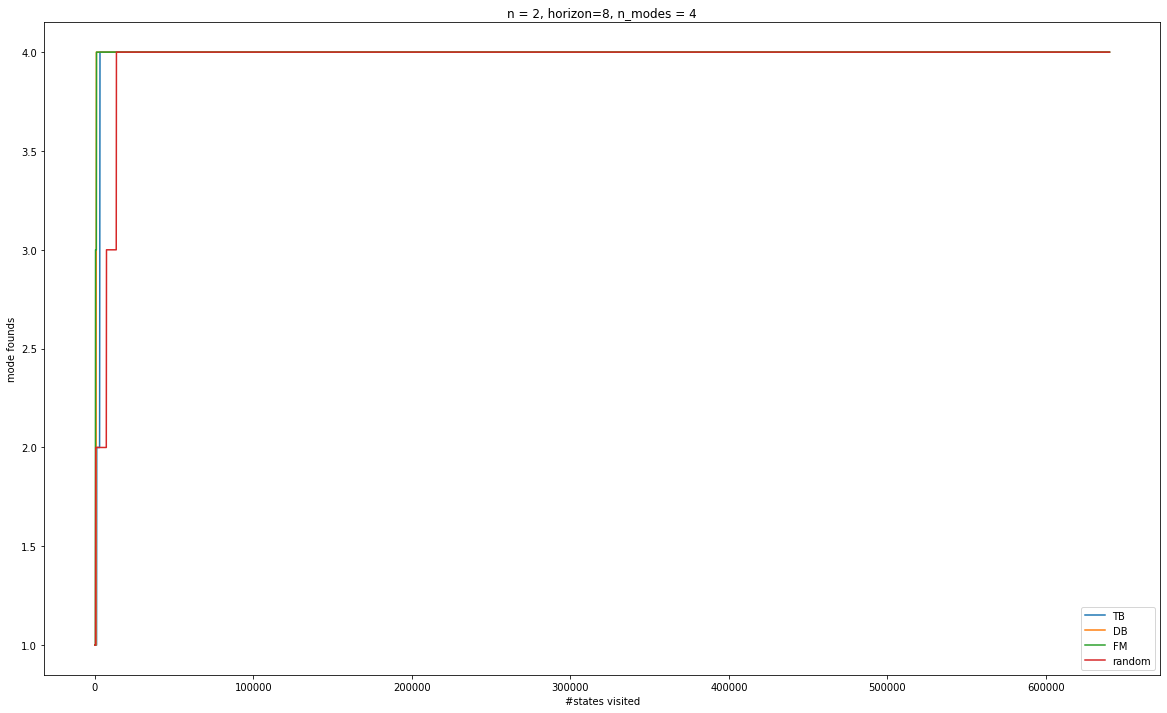

In [78]:
figsize=(5*4,3*4)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

ax1.plot(xs_TB, modes_founds_TB, label="TB")
ax1.plot(xs_DB, modes_founds_DB, label="DB")
ax1.plot(xs_FM, modes_founds_FM, label="FM")
ax1.plot(xs_random, modes_founds_random, label="random")
ax1.set(xlabel='#states visited', ylabel='mode founds')
ax1.set_title(f'n = {ndim}, horizon={H}, n_modes = {n_modes}')
ax1.legend()

# Load pretrained models and sample with



In [74]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = torch.load("/content/data_gfn.pth", map_location=device)

Run the samples sections above